# DO ZROBIENIA

- wszystko ma być w funkcjach
- tłumaczenie na angielski wszystkich plików i odwołań do nich tutaj
- przerobienie całego "constants" na słownik config = {} i wszystkie odwołania do stałych przerzucić na takie
- eleganckie po kolei wuywołanie wszystkiego

- trzymamy się jednej konwencji nazewniczej do funkcji... niech to będzie już `gen_cośtam()`

- tłumaczenie id of purchase w tabelach

- rentale nie mogą być oddane w nocy

1. wszystkie stałe, liczby itp do słownika `config` i odwołania w funkcjach
2. funkcje maja być bezargumentowe, oprócz trych które będą udekorowane jako @staticmethod itp. ale to jest zaznaczone
4. jest wywołanie tych funkcji wszystkich w jednej komórce

```python
sales = jakiś dataframe
sales = ogranij_cos_z_sales()

```

In [1]:
import datetime
import os
import random
from itertools import repeat
from pathlib import Path
import itertools
import holidays
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpy as np
import pandas as pd
from faker import Faker
from scipy.stats import expon, gamma, norm, randint, skewnorm, uniform
from unidecode import unidecode_expect_ascii

In [2]:
# constants
staff_number = 6
tournament_number = 20
customers_number = 1500
shop_lifetime_years = 2
traffic_decrease_magnitude = 4
shop_open_hours = {"from": 8, "to": 20, "pick": 17}
traffic_std = 1.5
rental_to_sales_ratio = 0.25
salary_settings = {"minimal": 3530, "exp_scale": 100}
weekday_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
}
customer_pcs_probas = {
    1: 0.7,
    2: 0.25,
    3: 0.05,
}
staff_shifts = {"morning": [1, 2], "afternoon": [3, 4, 6], "fired": [5]}
event_info = {"weekday": 4, "hour": 15}
initial_customer_n = 25
daily_customer_increment = 0.015  # to niech zostanie tyle
weekly_extras_multip = 1
weekly_extras = {
    0: 2,
    1: 1,
    2: 0,
    3: 4,
    4: 5,
    5: 5,
}
bulk_ratio = 0.35
inventory_multiplier = 1 
phone_num_prefixes = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]

avg_supply_yearly_rate = 3
rental_games_n = 70
inactive_rental_games = 3
rental_price_ratio = 0.2

rental_allowed_days = 3
penalty_ratio = 0.3

In [3]:

# DODATKOWE ATRYBUTY POTRZEBNE DO LOGIKI !!!!!!!!!!
phone_base = []
email_base = []


### Uwaga, musi być baza telefonów i emaili, bo między customerami i staff też muszą być one różne...

### UWAGI

# Faza 1 - przygotowanie

## Wczytanie csv

In [4]:
def file_path(file_name: str):
    dir_path = [i for i in Path.cwd().parents if i.name == "geeks-and-dragons-db"][0]
    path = os.path.join(dir_path, "config", "prompts", file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError("No such file")

In [5]:
prompt_games = pd.read_csv(file_path("gry.csv"))
prompt_first_names_males = pd.read_csv(file_path("imiona_m.csv"))
prompt_last_names_males = pd.read_csv(file_path("nazwiska_m.csv"))
prompt_first_names_females = pd.read_csv(file_path("imiona_k.csv"))
prompt_last_names_females = pd.read_csv(file_path("nazwiska_k.csv"))
prompt_cities = pd.read_csv(file_path("miasta.csv"))
prompt_emails = pd.read_csv(file_path("Domeny.csv"))
prompt_tournaments = pd.read_csv(file_path("turnieje.csv"), delimiter=";")

## Tabela prompt_dates

In [6]:
def gen_prompt_dates():
    # all the dates
    prompt_dates = pd.DataFrame(
        {
            "date": pd.date_range(
                end=datetime.datetime.now().date(), periods=365 * shop_lifetime_years
            )
        }
    )
    # weekdays
    prompt_dates["weekday"] = prompt_dates["date"].apply(lambda date: date.weekday())
    prompt_dates["weekday_name"] = prompt_dates["weekday"].map(weekday_dict)
    # filtering sundays and holidays
    holidays_pl = holidays.Poland()
    holiday_mask = prompt_dates["date"].apply(lambda date: date in holidays_pl)
    prompt_dates = prompt_dates[(prompt_dates["weekday"] != 6) & ~holiday_mask]
    # adding the base traffic volume
    ### initial numbe
    prompt_dates["volume_base"] = initial_customer_n
    ### a linear trend
    prompt_dates["volume_base"] += (
        np.repeat(daily_customer_increment, prompt_dates.shape[0]).cumsum().round()
    )
    ### additional traffic for each day
    prompt_dates["volume_base"] += (
        prompt_dates["weekday"].map(weekly_extras) * weekly_extras_multip
    )
    # adding sales and rental traffic
    ### sales = base + noise
    prompt_dates["volume_sales"] = (
        prompt_dates["volume_base"]
        + np.random.normal(loc=0, scale=traffic_std, size=prompt_dates.shape[0])
    ).round()
    ### rentals = base * ratio + noise
    prompt_dates["volume_rental"] = (
        prompt_dates["volume_base"] * rental_to_sales_ratio
        + np.random.normal(loc=0, scale=traffic_std, size=prompt_dates.shape[0])
    ).round()
    prompt_dates = prompt_dates.reset_index(drop=True)
    return prompt_dates

In [7]:
prompt_dates = gen_prompt_dates()

In [8]:
prompt_dates

,date,weekday,weekday_name,volume_base,volume_sales,volume_rental
0,2021-06-30,2,Wednesday,25.0,24.0,11.0
1,2021-07-01,3,Thursday,29.0,30.0,11.0
2,2021-07-02,4,Friday,30.0,29.0,11.0
3,2021-07-03,5,Saturday,30.0,29.0,14.0
4,2021-07-05,0,Monday,27.0,26.0,10.0
...,...,...,...,...,...,...
604,2023-06-24,5,Saturday,39.0,38.0,15.0
605,2023-06-26,0,Monday,36.0,37.0,12.0
606,2023-06-27,1,Tuesday,35.0,36.0,17.0
607,2023-06-28,2,Wednesday,34.0,36.0,14.0


## Tabela prompt_hours

In [9]:
def gen_prompt_hours():
    # list of the hours when opened
    prompt_hours = pd.DataFrame(
        {"hour": np.arange(start=shop_open_hours["from"], stop=shop_open_hours["to"])}
    )
    # traffic increments
    prompt_hours["customer_n"] = np.random.exponential(
        size=prompt_hours.shape[0]
    ).cumsum()
    # traffic decrements after the pick
    decrease_stage = prompt_hours[prompt_hours["hour"] > shop_open_hours["pick"]]
    prompt_hours.loc[decrease_stage.index, "customer_n"] -= np.random.exponential(
        scale=traffic_decrease_magnitude, size=decrease_stage.shape[0]
    ).cumsum()
    # probability column
    prompt_hours.loc[prompt_hours["customer_n"] < 0, "customer_n"] = 0
    prompt_hours["prob"] = prompt_hours["customer_n"] / prompt_hours["customer_n"].sum()
    return prompt_hours

In [10]:
prompt_hours = gen_prompt_hours()

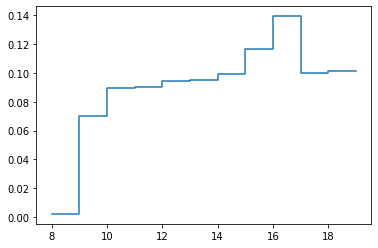

In [11]:
plt.step(range(8, 20), prompt_hours["prob"])

## Gry

In [12]:
def prepar_prompt_games():
    # sample the games but leave the first in csv as the first there
    prompt_games[1:] = prompt_games[1:].sample(frac=1)
    # add the weights
    rng = np.linspace(0, 2, prompt_games["Nazwa"].shape[0])
    expon_curve = expon.pdf(x=rng)
    prompt_games["weights"] = expon_curve / expon_curve.sum()

In [13]:
prepar_prompt_games()

In [14]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Liczba uczestników,weights
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,0.045967
1,Dixit Odyseja,karciana,towarzyska,"Dixit to narracyjna gra karciana, w której wym...",TAK,99.90,8.0,0.044128
2,Monopoly Classic,planszowa,familijna,Monopoly Standard to kultowa i znana na całym ...,TAK,115.90,6.0,0.042363
3,URATUJ STEFANA,planszowa,logiczna,"Celem wszystkich wyzwań, jest przesunięcie w s...",NIE,79.99,NaN,0.040669
4,Dobry rok,planszowa,strategiczna,"Gra ""Dobry Rok"" sprawdzi się u dzieci w wieku ...",NIE,160.97,NaN,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [15]:
id_generator = lambda n: [*range(1, n + 1)]


gender_generator = lambda n: random.choices(["M", "F"], weights=[0.5, 0.5], k=n)

# @staticmethod - leave the argument as it is!!!!
@np.vectorize
def _gen_one_phone(*args) -> str:
    while True:
        # get the prefix and the rest of digits
        digits = [
            np.random.choice(phone_num_prefixes),
            *np.random.randint(0, 10, size=7),
        ]
        # concat the digits
        phone = "".join(map(str, digits))
        if not phone in phone_base:
            break
    phone_base.append(phone)
    return phone


# @staticmethod - leave the argument as it is!!!!
@np.vectorize
def _gen_one_name(gender: str, mode: str) -> str:
    # first or last name colname mode
    if mode == "first":
        col = "imię"
        dfs = {"M": prompt_first_names_males, "F": prompt_first_names_females}
    elif mode == "last":
        col = "nazwisko"
        dfs = {"M": prompt_last_names_males, "F": prompt_last_names_females}
    else:
        raise ValueError(f"Cannot generate a name in {mode} mode")
    # random name based on gender and stats
    df = dfs[gender]
    return np.random.choice(df[col], p=df["prob"])


# @staticmethod - leave the argument as it is!!!!
@np.vectorize
def _gen_email(first_name: str, last_name: str) -> str:
    # join the names and cleanse it
    raw_name = f"{first_name.lower()}.{last_name.lower()}"
    cleansed_name = unidecode_expect_ascii(raw_name)
    # initially do not add the number after the name
    number = ""
    while True:
        # concat all the elements
        domain = np.random.choice(prompt_emails["Domena"])
        email = f"{cleansed_name}{number}@{domain}"
        # in the second iteration add the number
        number = np.random.randint(0, 10)
        if not email in email_base:
            break
    email_base.append(email)
    return email


# @staticmethod - leave the argument as it is!!!!
def _gen_staff_to_date() -> npt.NDArray:
    # NULL fill
    dates = np.zeros(staff_number, dtype=np.object_)
    dates[:] = np.nan
    # find the constants
    some_employee_ix = -2
    shop_open_date = prompt_dates["date"].iloc[0]
    today = prompt_dates["date"].iloc[-1]
    # fire him
    dates[some_employee_ix] = Faker().date_between(
        shop_open_date + datetime.timedelta(days=90),
        today - datetime.timedelta(days=90),
    )
    return dates


# @staticmethod - leave the argument as it is!!!!
def _gen_staff_form_date(staff: pd.DataFrame) -> npt.NDArray:
    # hire all of them
    dates = np.zeros(staff_number, dtype=np.object_)
    dates[:] = prompt_dates["date"].iloc[0]
    # hire one with a time shift
    some_employee_ix = -1
    ones_end_date = staff["to_date"].loc[staff["to_date"].isnull() == False].values[0]
    dates[some_employee_ix] = ones_end_date + datetime.timedelta(days=30)
    return dates


def _gen_staff_update_time(staff: pd.DataFrame) -> npt.NDArray:
    df_date = staff[["to_date", "from_date"]]
    return df_date.max(axis=1, skipna=True, numeric_only=False).apply(
        lambda date: date
        + pd.DateOffset(
            hours=random.choice(range(8, 20)),
            minutes=random.choice(range(0, 60)),
            seconds=random.choice(range(0, 60)),
        )
    ) 


# @staticmethod - leave the argument as it is!!!!
def _gen_salary(staff: pd.DataFrame) -> npt.NDArray:
    # over the base salary
    salaries = np.random.exponential(
        scale=salary_settings["exp_scale"],
        size=staff.shape[0],
    )
    # add the base
    salaries += salary_settings["minimal"]
    # round it
    salaries = salaries.round(2)
    # remove the salary for the fired ones
    ix = staff.loc[staff["to_date"].isnull() == False]
    salaries[ix.index] = np.nan
    return salaries

# @staticmethod - leave the argument as it is!!!!
def _gen_manager_status(staff: pd.DataFrame) -> npt.NDArray:
    # on entry no managers
    status = np.full(staff.shape[0], False)
    # the one who has the greatest salary becoms a manager
    ix = staff.loc[staff["current_salary"] == staff["current_salary"].max()]
    status[ix.index] = True
    return status

In [16]:
def staff_df_generator():
    # basic info
    staff = pd.DataFrame(
        {
            "gender": np.random.choice(["M", "F"], size=staff_number),
            "phone": _gen_one_phone(np.zeros(staff_number)),
            "to_date": _gen_staff_to_date(),
        }
    )
    # details
    staff["city"] = np.full(staff.shape[0], "Wrocław")
    staff["from_date"] = _gen_staff_form_date(staff)
    staff["first_name"] = _gen_one_name(staff["gender"], "first")
    staff["last_name"] = _gen_one_name(staff["gender"], "last")
    staff["email"] = _gen_email(staff["first_name"], staff["last_name"])
    staff["current_salary"] = _gen_salary(staff)
    staff["is_manager"] = _gen_manager_status(staff)
    staff["updated_at"] = _gen_staff_update_time(staff)
    # indexing
    staff.sort_values(by=["updated_at"], inplace=True)
    staff["staff_id"] = staff.reset_index()["index"] + 1
    staff = staff.reindex(
        labels=[
            "staff_id",
            "first_name",
            "last_name",
            "phone",
            "email",
            "city",
            "current_salary",
            "is_manager",
            "gender",
            "from_date",
            "to_date",
            "updated_at",
        ],
        axis=1,
    )
    return staff

In [17]:
staff = staff_df_generator()
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,WERONIKA,JANAS,791177821,weronika.janas@allegro.pl,Wrocław,3553.81,False,F,2021-06-30,NaN,2021-06-30 08:43:30
0,2,LISA,SKOCZYLAS,530294292,lisa.skoczylas@yahoo.com,Wrocław,3532.53,False,F,2021-06-30,NaN,2021-06-30 10:39:28
2,3,JAKUB,WOJCIECHOWSKI,799810206,jakub.wojciechowski@home.pl,Wrocław,3731.00,False,M,2021-06-30,NaN,2021-06-30 11:40:13
3,4,SOFIIA,PAWLAK,694627424,sofiia.pawlak@gazeta.pl,Wrocław,3556.27,False,F,2021-06-30,NaN,2021-06-30 19:48:58
4,5,ANNA,BACZYŃSKA,512616648,anna.baczynska@tlenofon.pl,Wrocław,NaN,False,F,2021-06-30,2021-10-16,2021-10-16 19:50:42
5,6,MILENA,PAWLIK,668245084,milena.pawlik@poczta.pl,Wrocław,3821.11,True,F,2021-11-15,NaN,2021-11-15 08:21:17


## Godziny pracy

In [18]:
def gen_prompt_staff_shifts():
    # all the hour-day combinations
    staff_shifts = {"morning": [1, 2], "afternoon": [3, 4, 6], "fired": [5]}
    hours = pd.DataFrame(
        {"hour": np.arange(shop_open_hours["from"], shop_open_hours["to"])}
    )
    weekdays = pd.DataFrame({"weekday": np.arange(0, 7)})
    shifts = pd.merge(hours, weekdays, how="cross")
    # get the morning and afternoon shift hours
    morning_rows = shifts[
        ((shifts["weekday"] <= 4) & (shifts["hour"] >= 8) & (shifts["hour"] < 15))
        | ((shifts["weekday"] > 4) & (shifts["hour"] >= 8) & (shifts["hour"] < 13))
    ]
    afternoon_rows = shifts[
        ((shifts["weekday"] <= 3) & (shifts["hour"] >= 14) & (shifts["hour"] < 20))
        | ((shifts["weekday"] > 3) & (shifts["hour"] >= 12) & (shifts["hour"] < 20))
    ]
    # add the employees to each field
    afternoons = pd.merge(
        pd.DataFrame({"staff_id": staff_shifts["afternoon"]}),
        afternoon_rows,
        how="cross",
    )
    mornings = pd.merge(
        pd.DataFrame({"staff_id": staff_shifts["morning"]}), morning_rows, how="cross"
    )
    return pd.concat([mornings, afternoons]).reset_index(drop=True)

In [19]:
prompt_staff_shifts = gen_prompt_staff_shifts()
prompt_staff_shifts

,staff_id,hour,weekday
0,1,8,0
1,1,8,1
2,1,8,2
3,1,8,3
4,1,8,4
...,...,...,...
229,6,19,2
230,6,19,3
231,6,19,4
232,6,19,5


## Związki

In [20]:
# losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all() == False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [21]:



def realtionships_df_generator(staff_df):
    n = int(np.ceil(staff_number * 1.5))
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df["current_salary"].isnull() == False]
    for i in range(n):
        employee = random.choices(
            staff_df.staff_id.values, weights=staff_df.current_salary.values
        )
        staff_id.append(*employee)
        staff_gender.append(
            *staff_df["gender"].loc[staff_df.staff_id == employee[0]].values
        )
        update.append(
            Faker().date_between_dates(
                pd.to_datetime(
                    staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]
                ),
                prompt_dates["date"].iloc[-1],
            )
            + pd.DateOffset(
                hours=random.choice(range(8, 20)),
                minutes=random.choice(range(0, 60)),
                seconds=random.choice(range(0, 60)),
            )
        )
    df = pd.DataFrame(
        {
            "staff_id": staff_id,
            "staff_gender": staff_gender,
            "dates_number": norm_with_condition_generator(n, 5, 2, 0),
            "updated_at": update,
        }
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["relationship_id"] = id_generator(df.shape[0])
    df["partner_id"] = id_generator(df.shape[0])
    df = df.reindex(
        labels=[
            "relationship_id",
            "staff_id",
            "staff_gender",
            "partner_id",
            "dates_number",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [22]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
8,1,3,M,1,2,2021-07-07 14:56:05
0,2,2,F,2,2,2021-07-10 13:41:23
1,3,2,F,3,3,2021-10-22 08:54:33
5,4,6,F,4,5,2022-01-09 10:49:46
2,5,6,F,5,5,2022-12-06 13:29:19
3,6,4,F,6,5,2023-03-22 18:21:40
7,7,1,F,7,5,2023-04-10 14:21:46
6,8,1,F,8,7,2023-05-08 08:53:11
4,9,6,F,9,8,2023-06-12 17:37:59


## Partnerzy

In [23]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == "M":
            gender.append(random.choices(["M", "F"], weights=[0.1, 0.9])[0])
        elif el == "F":
            gender.append(random.choices(["M", "F"], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame(
        {
            "partner_id": partner,
            "gender": gender,
            "updated_at": relationships_df.updated_at,
        }
    )
    partners["name"] = _gen_one_name(partners["gender"], mode="first")
    partners.sort_values(by=["updated_at"], inplace=True)
    partners = partners.reindex(
        labels=["partner_id", "name", "gender", "updated_at"], axis=1
    )
    return partners

In [24]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
8,1,LILIA,F,2021-07-07 14:56:05
0,2,HENRYK,M,2021-07-10 13:41:23
1,3,KERIM,M,2021-10-22 08:54:33
5,4,MATEUSZ,M,2022-01-09 10:49:46
2,5,WALDEMAR,M,2022-12-06 13:29:19
3,6,ARKADIUSZ,M,2023-03-22 18:21:40
7,7,TETIANA,F,2023-04-10 14:21:46
6,8,WOJCIECH,M,2023-05-08 08:53:11
4,9,MARCIN,M,2023-06-12 17:37:59


## Klienci - część A

In [25]:
customers = pd.DataFrame({"customer_id": id_generator(customers_number)})

## Koszty utrzymania

In [26]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(
        prompt_dates.loc[
            (prompt_dates["date"].dt.day == day)
            | (prompt_dates["date"].dt.day == day + 1),
            "date",
        ]
    )
    base["flag"] = base["date"].dt.to_period("M")
    base.drop_duplicates(["flag"], keep="first", inplace=True)
    base = base.reset_index()
    return base["date"]

In [27]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "CZYNSZ " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": np.full((1, date_df.shape[0]), 3250)[0],
            "type": np.full((1, date_df.shape[0]), "CZYNSZ")[0],
        }
    )
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "ENERGIA ELEKTRYCZNA " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [
                max(round(norm.rvs(150, 4), 2), 100) for i in range(date_df.shape[0])
            ],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def water_generator():
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "WODA " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [
                max(round(norm.rvs(50, 2), 2), 15) for i in range(date_df.shape[0])
            ],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    for j in range(2021, 2024):
        for i in range(4, 11):
            day = datetime.datetime(j, i, 5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "OGRZEWANIE " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [round(norm.rvs(100, 4), 2) for i in range(date_df.shape[0])],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat(
        [staff_df[["first_name", "last_name", "current_salary"]]] * date_df.shape[0],
        ignore_index=True,
    )
    staff_name = staff_df["first_name"].str.cat(staff_df["last_name"], sep=" ")
    names = pd.concat([staff_name] * date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()["date"]
    title_first = dates.dt.month_name(locale="pl_PL").apply(
        lambda x: "PENSJA " + str(x).upper()
    )
    title = title_first.str.cat(names, sep=" ")
    df = pd.DataFrame(
        {
            "date": dates,
            "title": title,
            "amount": all_staff["current_salary"],
            "type": np.full((1, title.shape[0]), "PENSJA")[0],
        }
    )
    to_date = pd.to_datetime(
        staff_df["to_date"].loc[staff_df["to_date"].isnull() == False].values[0]
    )
    df.loc[(df["amount"].isnull() == True) & (df["date"] < to_date), "amount"] = round(
        3490 + expon.rvs(scale=100, loc=80), 2
    )
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame(
        {"date": [], "title": [], "amount": [], "type": [], "updated_at": []}
    )
    df = pd.concat(
        [
            df,
            rent_generator(),
            energy_generator(),
            water_generator(),
            heat_generator(),
            salary_generator(staff),
        ]
    )
    df["updated_at"] = df["date"].apply(
        lambda x: x
        + pd.DateOffset(
            hours=random.choice(range(8, 20)),
            minutes=random.choice(range(0, 60)),
            seconds=random.choice(range(0, 60)),
        )
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["payment_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df["spend_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "spend_id",
            "title",
            "amount",
            "type",
            "date",
            "payment_id",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [28]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
4,1,ENERGIA ELEKTRYCZNA LIPIEC,145.69,MEDIA,2021-07-05,1,1,2021-07-05 09:21:35
4,2,CZYNSZ LIPIEC,3250.00,CZYNSZ,2021-07-05,2,2,2021-07-05 14:36:29
4,3,WODA LIPIEC,51.69,MEDIA,2021-07-05,3,3,2021-07-05 14:48:42
0,4,PENSJA LIPIEC WERONIKA JANAS,3553.81,PENSJA,2021-07-10,4,4,2021-07-10 09:04:01
3,5,PENSJA LIPIEC SOFIIA PAWLAK,3556.27,PENSJA,2021-07-10,5,5,2021-07-10 09:15:45
...,...,...,...,...,...,...,...,...
143,184,PENSJA CZERWIEC MILENA PAWLIK,3821.11,PENSJA,2023-06-10,184,184,2023-06-10 14:11:07
141,185,PENSJA CZERWIEC SOFIIA PAWLAK,3556.27,PENSJA,2023-06-10,185,185,2023-06-10 15:55:53
138,186,PENSJA CZERWIEC WERONIKA JANAS,3553.81,PENSJA,2023-06-10,186,186,2023-06-10 17:59:07
140,187,PENSJA CZERWIEC JAKUB WOJCIECHOWSKI,3731.00,PENSJA,2023-06-10,187,187,2023-06-10 18:30:09


## Typy wydatków

In [29]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame(
        {"expenses_type": expense_df["type"], "updated_at": expense_df["updated_at"]}
    )
    df.drop_duplicates(subset=["expenses_type"], keep="last", inplace=True)
    df.sort_values(by=["updated_at"], inplace=True)
    df["expenses_type_id"] = id_generator(df.shape[0])
    df = df.reindex(["expenses_type_id", "expenses_type", "updated_at"], axis=1)
    return df

In [30]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
588,1,MEDIA,2023-06-05 16:30:59
588,2,CZYNSZ,2023-06-05 17:21:05
139,3,PENSJA,2023-06-10 19:18:31


## Tytuły wydatków

In [31]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame(
        {
            "title": expense_df["title"],
            "expenses_type": expense_df["type"],
            "updated_at": expense_df["updated_at"],
        }
    )
    df.drop_duplicates(subset=["title"], keep="last", inplace=True)
    df = pd.merge(
        df,
        expense_types_df[["expenses_type_id", "expenses_type"]],
        how="left",
        on=["expenses_type"],
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["title_id"] = id_generator(df.shape[0])
    df = df.reindex(["title_id", "title", "expenses_type_id", "updated_at"], axis=1)
    return df

In [32]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA LIPIEC ANNA BACZYŃSKA,3,2021-07-10 18:21:17
1,2,PENSJA SIERPIEŃ ANNA BACZYŃSKA,3,2021-08-10 15:51:41
2,3,PENSJA WRZESIEŃ ANNA BACZYŃSKA,3,2021-09-10 16:37:02
3,4,PENSJA PAŹDZIERNIK ANNA BACZYŃSKA,3,2021-10-11 08:14:09
4,5,WODA LUTY,1,2022-02-05 10:37:36


## Wydatki i tytuły jeszcze raz

In [33]:
maintenance_expenses2 = pd.merge(
    maintenance_expenses, expense_titles[["title_id", "title"]], how="left", on="title"
)
maintenance_expenses2.sort_values(by=["updated_at"], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(
    [
        "spend_id",
        "title_id",
        "type",
        "amount",
        "payment_id",
        "invoice_id",
        "updated_at",
    ],
    axis=1,
)

In [34]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,14,MEDIA,145.69,1,1,2021-07-05 09:21:35
1,2,15,CZYNSZ,3250.00,2,2,2021-07-05 14:36:29
2,3,13,MEDIA,51.69,3,3,2021-07-05 14:48:42
3,4,19,PENSJA,3553.81,4,4,2021-07-10 09:04:01
4,5,18,PENSJA,3556.27,5,5,2021-07-10 09:15:45


## Turnieje

In [35]:
def game_tournament_generator():
    games = prompt_games.loc[
        prompt_games["Turniej"] == "TAK", ["Nazwa", "rodzaj", "kategoria"]
    ]
    tournament_games = pd.merge(
        games,
        prompt_tournaments,
        left_on=["rodzaj", "kategoria"],
        right_on=["Rodzaj", "Kategoria"],
        suffixes=["_gry", "_turnieju"],
    )
    tournament_games = tournament_games[["Nazwa_gry", "Nazwa_turnieju"]]
    return tournament_games


def _gen_staff_handler():
    # 
    available_staff = prompt_staff_shifts.loc[
        (prompt_staff_shifts["weekday"] == event_info["weekday"]) & (prompt_staff_shifts["hour"] >= event_info["hour"])
    ]["staff_id"].unique()

    return np.random.choice(available_staff)


def count_matches(x):
    # na to jest gotowy wzór analityczny xDDDDDDDD
    total = 0
    while x >= 0:
        total += 2 ** x
        x -= 1
    return total

In [36]:
prompt_dates.loc[prompt_dates["weekday"] == event_info["weekday"], "date"].iloc[5::6]

32    2021-08-06
68    2021-09-17
104   2021-10-29
138   2021-12-10
171   2022-01-21
207   2022-03-04
243   2022-04-15
277   2022-05-27
312   2022-07-08
347   2022-08-19
383   2022-09-30
423   2022-11-18
458   2022-12-30
499   2023-02-17
535   2023-03-31
568   2023-05-12
603   2023-06-23
Name: date, dtype: datetime64[ns]

In [37]:
def tournaments_df_generator():
    dates = pd.DataFrame(
        prompt_dates.loc[prompt_dates["weekday"] == event_info["weekday"], "date"].iloc[5::6] # added 5 because of the errors
    ).reset_index()["date"]
    tournament = game_tournament_generator()
    tournament = tournament.sample(
        dates.shape[0], replace=False, ignore_index=True
    )  # nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=dates.shape[0])
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame(
        {
            "name": tournament["Nazwa_turnieju"],
            "game": tournament["Nazwa_gry"],
            "start_time": dates + datetime.timedelta(hours=15),
            "matches": matches,
            "tree_levels": tree_levels_number,
            "fee": np.full((1, dates.shape[0]), 50)[0],
            "sign_up_deadline": dates
            - datetime.timedelta(days=3)
            + datetime.timedelta(hours=20),
            "staff_id": [_gen_staff_handler() for i in range(dates.shape[0])],
            "expenses": map(
                lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=dates.shape[0])
            ),
            "updated_at": dates.apply(
                lambda x: x
                + datetime.timedelta(
                    hours=15,
                    minutes=random.randint(1, 5),
                    seconds=random.randint(1, 59),
                )
            ),
        }
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["tournament_id"] = df.reset_index()["index"]
    df["invoice_id"] = df["tournament_id"]
    df = df.reindex(
        [
            "tournament_id",
            "name",
            "game",
            "start_time",
            "matches",
            "tree_levels",
            "fee",
            "sign_up_deadline",
            "staff_id",
            "expenses",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [38]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,invoice_id,updated_at
0,0,Familijna Rewolucja,Monopoly Classic,2021-08-06 15:00:00,15,3,50,2021-08-03 20:00:00,3,224.00,0,2021-08-06 15:01:50
1,1,Krucjata Karcianych Mistrzów,UNO,2021-09-17 15:00:00,15,3,50,2021-09-14 20:00:00,6,236.49,1,2021-09-17 15:01:31
2,2,Krucjata Karcianych Mistrzów,Tajniacy,2021-10-29 15:00:00,15,3,50,2021-10-26 20:00:00,6,221.73,2,2021-10-29 15:03:10
3,3,Wrocławski Konwent Planszówkowy,Scythe,2021-12-10 15:00:00,7,2,50,2021-12-07 20:00:00,3,214.37,3,2021-12-10 15:04:58
4,4,Labirynt Logicznych Umysłów,Mastermind,2022-01-21 15:00:00,15,3,50,2022-01-18 20:00:00,3,212.73,4,2022-01-21 15:02:53


## Udziały

In [39]:
deadline = pd.to_datetime("2022-04-23")

In [40]:
def sign_up_date_generator(deadline):
    deadline = pd.to_datetime(deadline)
    date = pd.to_datetime(
        prompt_dates["date"]
        .loc[
            (prompt_dates["date"] < deadline)
            & (prompt_dates["date"] > deadline - pd.DateOffset(days=14))
        ]
        .sample(1, ignore_index=True)
        .values[0]
    )
    date += pd.DateOffset(
        hours=random.choice(range(8, 20)),
        minutes=random.choice(range(0, 60)),
        seconds=random.choice(range(0, 60)),
    )
    return date

In [41]:
def participations_df_generator():
    # liczba uczestników
    players = pd.merge(
        tournaments[
            ["game", "tree_levels", "tournament_id", "fee", "sign_up_deadline"]
        ],
        prompt_games[["Nazwa", "Liczba uczestników"]],
        left_on=["game"],
        right_on=["Nazwa"],
        how="left",
    )
    players["Liczba uczestników"] = players["Liczba uczestników"].astype("int")
    players_number = players["Liczba uczestników"] * (2 ** players["tree_levels"])
    players["players"] = players_number

    # customer_id i miejsce
    participants = map(
        lambda x: customers["customer_id"]
        .sample(x, replace=False, ignore_index=True)
        .values,
        players_number,
    )
    players["place"] = players["players"].apply(lambda x: [*range(1, x + 1)])
    players["customer_id"] = list(participants)

    # ostateczny df
    df = players[["tournament_id", "customer_id", "fee", "sign_up_deadline", "place"]]
    df = df.explode(["customer_id", "place"], ignore_index=True)
    df["sign_up_date"] = df["sign_up_deadline"].apply(sign_up_date_generator)
    df["updated_at"] = df["sign_up_date"].copy()
    df.sort_values(by=["updated_at"], inplace=True)
    df["particip_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "particip_id",
            "tournament_id",
            "customer_id",
            "place",
            "sign_up_date",
            "fee",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [42]:
participations = participations_df_generator()
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,invoice_id,updated_at
41,1,0,522,42,2021-07-21 08:15:53,50,1,2021-07-21 08:15:53
19,2,0,1258,20,2021-07-21 09:18:48,50,2,2021-07-21 09:18:48
5,3,0,1292,6,2021-07-22 08:36:29,50,3,2021-07-22 08:36:29
0,4,0,697,1,2021-07-22 10:43:01,50,4,2021-07-22 10:43:01
46,5,0,284,47,2021-07-22 11:03:52,50,5,2021-07-22 11:03:52


## Magazyn

In [43]:
v_repeat = np.vectorize(lambda date, volume: itertools.repeat(date, int(volume)))


# def get_value_from_another_column(df, search_column, search_value, target_column):
#     matching_rows = df.loc[df[search_column] == search_value]
#     target_value = matching_rows[target_column].values[0]
#     return target_value


def _gen_sell_inventory() -> pd.DataFrame:
    # evaluate a total game number
    total_games_n = np.round(
        prompt_dates["volume_sales"].sum()
        * (inventory_multiplier + np.random.exponential())
    )
    game_counts = list(map(round, prompt_games["weights"] * total_games_n))
    # repeat the games
    games_gener = itertools.chain(*v_repeat(prompt_games["Nazwa"], game_counts))
    games = np.array(list(games_gener))
    # add the basic details to the data frame
    s_inventory = pd.DataFrame(
        {
            "game": np.random.permutation(games),
            "destination": np.full(games.size, "S"),
            "active": np.full(games.size, True),
        }
    )
    # add the prices from the prompt table
    s_inventory = (
        pd.merge(
            s_inventory,
            prompt_games[["Nazwa", "Kupno"]],
            left_on="game",
            right_on="Nazwa",
            how="inner",
        )
        .rename(columns={"Kupno": "price"})
        .drop(columns="Nazwa")
    )
    # add the procurment prices as some fraction of the standard one
    s_inventory["purchase_payment"] = (s_inventory["price"] * bulk_ratio).round(2)
    s_inventory = s_inventory.sample(n=s_inventory.shape[0]).reset_index(drop=True)
    # get the delivery dates
    delivery_count = avg_supply_yearly_rate * shop_lifetime_years
    delivery_dates = prompt_dates["date"][
        :: int(prompt_dates.shape[0] / delivery_count)
    ].copy()
    delivery_dates += datetime.timedelta(hours=8)
    # the final grouping
    group_dates = np.repeat(
        delivery_dates.to_numpy(), np.ceil(total_games_n / delivery_count)
    )[: sum(game_counts)]
    s_inventory = s_inventory.reset_index(drop=True)
    s_inventory["delivery_date"] = group_dates
    return s_inventory


def _gen_rent_inventory() -> pd.DataFrame:
    total_games_n = rental_games_n
    game_counts = list(map(round, prompt_games["weights"] * total_games_n))
    # repeat the games
    games_gener = itertools.chain(*v_repeat(prompt_games["Nazwa"], game_counts))
    games = np.array(list(games_gener))
    # active statuses
    active_status = np.full(games.size, True)
    active_status[:inactive_rental_games] = False
    active_status = np.random.permutation(active_status)
    # add the basic details to the data frame
    r_inventory = pd.DataFrame(
        {
            "game": np.random.permutation(games),
            "destination": np.full(games.size, "R"),
            "active": active_status,
        }
    )
    # add the prices from the prompt table; temporarily prices are full
    r_inventory = (
        pd.merge(
            r_inventory,
            prompt_games[["Nazwa", "Kupno"]],
            left_on="game",
            right_on="Nazwa",
            how="inner",
        )
        .rename(columns={"Kupno": "price"})
        .drop(columns="Nazwa")
    )
    # add the procurment prices as some fraction of the standard one
    r_inventory["purchase_payment"] = (r_inventory["price"] * bulk_ratio).round(2)
    # the delivery dates
    r_inventory["delivery_date"] = prompt_dates["date"].iloc[0] + datetime.timedelta(
        hours=8
    )
    r_inventory["price"] = (r_inventory["price"] * rental_price_ratio).round(2)
    return r_inventory


def _gen_tournament_inventory() -> pd.DataFrame:
    # find the required game counts
    game_counts_tournaments = (
        tournaments[["game", "tree_levels"]]
        .groupby("game")
        .max()
        .apply(lambda x: 2 ** x)
    ).reset_index()
    # repeat the games
    games_gener = itertools.chain(
        *v_repeat(
            game_counts_tournaments["game"], game_counts_tournaments["tree_levels"]
        )
    )
    games = np.array(list(games_gener))

    # add the basic details to the data frame
    t_inventory = pd.DataFrame(
        {
            "game": np.random.permutation(games),
            "destination": np.full(games.size, "T"),
            "active": np.full(games.size, True),
        }
    )
    t_inventory = (
        pd.merge(
            t_inventory,
            prompt_games[["Nazwa", "Kupno"]],
            left_on="game",
            right_on="Nazwa",
            how="inner",
        )
        .rename(columns={"Kupno": "price"})
        .drop(columns="Nazwa")
    )
    # add the procurment prices as some fraction of the standard one
    t_inventory["purchase_payment"] = (t_inventory["price"] * bulk_ratio).round(2)
    # the delivery dates
    t_inventory["delivery_date"] = prompt_dates["date"].iloc[0] + datetime.timedelta(
        hours=8
    )
    t_inventory["price"] = np.nan
    return t_inventory


def gen_inventory():
    # concat the parts
    inventory = pd.concat(
        [_gen_sell_inventory(), _gen_rent_inventory(), _gen_tournament_inventory()]
    )
    # add updated at value
    inventory["updated_at"] = inventory["delivery_date"]
    inventory = inventory.sort_values(by=["updated_at"])
    # index it
    inventory = inventory.reset_index(drop=True)
    inventory["inventory_id"] = inventory.reset_index()["index"] + 1
    # add invoice numbers
    uniq_dates = np.sort(np.unique(inventory["delivery_date"]))
    invoice_translator = dict(zip(uniq_dates, np.arange(uniq_dates.size) + 1))
    inventory["invoice_id"] = inventory["delivery_date"].map(invoice_translator)
    # export it
    inventory = inventory.reindex(
        [
            "inventory_id",
            "game",
            "destination",
            "price",
            "active",
            "purchase_payment",
            "invoice_id",
            "delivery_date",
            "updated_at",
        ],
        axis=1,
    )
    return inventory

In [44]:
inventory = gen_inventory()

## Ceny gier

In [45]:
def game_prices_df_generator(inventory_df):
    df = inventory_df.drop_duplicates(subset=["price"], keep="last", ignore_index=True)[
        ["price", "updated_at"]
    ]
    df.rename(columns={"price": "current_price"}, inplace=True)
    df = df.sort_values(["updated_at"])
    df["price_id"] = id_generator(df.shape[0])
    df = df.reindex(["price_id", "current_price", "updated_at"], axis=1)
    return df

In [46]:
game_prices = game_prices_df_generator(inventory)
game_prices.head()

,price_id,current_price,updated_at
0,1,19.98,2021-06-30 08:00:00
25,2,9.18,2021-06-30 08:00:00
26,3,5.24,2021-06-30 08:00:00
27,4,12.18,2021-06-30 08:00:00
28,5,8.00,2021-06-30 08:00:00


## Sprzedaże

In [47]:
def gen_sales():
    v_repeat = np.vectorize(lambda date, volume: itertools.repeat(date, int(volume)))
    v_timedelta = np.vectorize(
        lambda h, m, s: datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))
    )
    @np.vectorize
    def v_get_staff_id(timestamp):
        available_staff = prompt_staff_shifts[
            (prompt_staff_shifts["weekday"] == timestamp.weekday())
            & (prompt_staff_shifts["hour"] == timestamp.hour)
        ]["staff_id"]
        return np.random.choice(available_staff)


    # get a list of dates for each customer
    dates_gener = itertools.chain(
        *v_repeat(prompt_dates["date"], prompt_dates["volume_sales"])
    )
    dates = np.array(list(dates_gener))
    # add random time to the date
    hours = np.array(
        np.random.choice(prompt_hours["hour"], p=prompt_hours["prob"], size=dates.size)
    )
    minutes = np.random.randint(0, 59, size=dates.size)
    seconds = np.random.randint(0, 59, size=dates.size)
    timestamps = dates + v_timedelta(hours, minutes, seconds)
    timestamps.sort()
    # staff ids
    staff = v_get_staff_id(timestamps)
    # how many at once are bought
    pcs = np.random.choice(
        list(customer_pcs_probas.keys()),
        p=list(customer_pcs_probas.values()),
        size=dates.size,
    )
    # make a data frame and add invoices as ix
    sales = pd.DataFrame({"date": timestamps, "staff_id": staff, "pcs": pcs})
    sales = sales.reset_index().rename(columns={"index": "invoice"})
    # additional rows when the pieces number is larger than one
    for pcs_n in customer_pcs_probas.keys():
        selection = sales[sales["pcs"] == pcs_n]
        sales = pd.concat([sales] + [selection] * (pcs_n - 1))
    sales = sales.reset_index(drop=True).drop("pcs", axis="columns")
    # pre-filter the inventory table
    global inventory # DELETE THAT!!!!!!!!!!!
    sales_inventory = inventory[inventory["destination"] == "S"]
    sales = pd.concat(
        [
            sales,
            sales_inventory.iloc[: sales.shape[0]].reset_index()[
                ["inventory_id", "price", "delivery_date"]
            ],
        ],
        axis=1,
    )
    sales = sales[~(sales["date"] < sales["delivery_date"])]
    sales = sales.drop(columns=["delivery_date"])
    inventory.loc[sales["inventory_id"], "active"] = False
   
    # other details
    sales["updated_at"] = sales["date"]
    sales["return_oper"] = False
    # fix
    sales = sales.reset_index(drop=True)
    sales["sale_id"] = sales.reset_index()["index"]
    # export
    sales.sort_values("updated_at", inplace=True)
    sales = sales.reindex(
        [
            "sale_id",
            "inventory_id",
            "staff_id",
            "price",
            "date",
            "invoice",
            "return_oper",
            "updated_at",
        ],
        axis=1,
    )
    return sales

In [48]:
sales = gen_sales()

In [49]:
sales

,sale_id,inventory_id,staff_id,price,date,invoice,return_oper,updated_at
0,0,1,2,119.99,2021-06-30 10:35:45,0,False,2021-06-30 10:35:45
1,1,2,2,90.00,2021-06-30 11:24:22,1,False,2021-06-30 11:24:22
2,2,3,2,129.99,2021-06-30 11:26:50,2,False,2021-06-30 11:26:50
3,3,4,2,119.90,2021-06-30 11:31:55,3,False,2021-06-30 11:31:55
4,4,5,2,119.99,2021-06-30 11:44:45,4,False,2021-06-30 11:44:45
...,...,...,...,...,...,...,...,...
22351,22351,24796,4,81.46,2023-06-29 18:56:42,19683,False,2023-06-29 18:56:42
19684,19684,19849,6,81.46,2023-06-29 19:42:15,19684,False,2023-06-29 19:42:15
22705,22705,25776,6,32.99,2023-06-29 19:42:15,19684,False,2023-06-29 19:42:15
23059,23059,26756,6,119.30,2023-06-29 19:42:15,19684,False,2023-06-29 19:42:15


In [50]:
def rental_df_generator():
    rental_date = []
    return_date = []
    customer = []
    price = []
    staff = []
    inventory_ids = []
    rate = []
    update = []
    penalty = []
    invoice = []
    penalty_invoice = []

    @np.vectorize
    def v_get_staff_id(timestamp):
        available_staff = prompt_staff_shifts[
            (prompt_staff_shifts["weekday"] == timestamp.weekday())
            & (prompt_staff_shifts["hour"] == timestamp.hour)
        ]["staff_id"]
        return np.random.choice(available_staff)

    for j in range(prompt_dates["date"].shape[0]):
        for i in range(int(prompt_dates["volume_rental"][j])):
            hour = random.choices(
                prompt_hours["hour"], weights=prompt_hours["prob"], k=1
            )[0]
            date = prompt_dates["date"][j] + datetime.timedelta(
                hours=int(hour),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            game = np.random.choice(prompt_games["Nazwa"], p=prompt_games["weights"])
            staff_id = v_get_staff_id(date)
            holding_time = gamma.rvs(scale=3, a=2)
            return_date_t = prompt_dates["date"][j] + datetime.timedelta(
                days=int(holding_time),
                hours=round(abs(holding_time) % 1 * 24, 2),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            mask = (
                (inventory["game"] == game)
                & (inventory["delivery_date"] < date)
                & (inventory["destination"] == "R")
                & (inventory["active"] == True)
            )
            if mask.any():
                customer.append(int(random.choice(customers["customer_id"])))
                price.append(inventory["price"].loc[mask.idxmax()])
                rental_date.append(date)
                staff.append(staff_id)
                game_inventory_id = inventory["inventory_id"].loc[mask.idxmax()]
                inventory_ids.append(game_inventory_id)
                invoice.append(f"{i}{j}")
                if return_date_t > datetime.datetime.today():
                    return_date.append(np.nan)
                    update.append(date)
                    inventory.loc[mask.idxmax(), "active"] = False
                    penalty.append(np.nan)
                    penalty_invoice.append(np.nan)
                else:
                    return_date.append(return_date_t)
                    update.append(return_date_t)
                    delta = return_date_t - date
                    if delta.days > rental_allowed_days:
                        penalty.append(
                            (
                                (
                                    inventory[
                                        inventory["inventory_id"] == game_inventory_id
                                    ]["price"]
                                )
                                * penalty_ratio
                            )
                            .to_numpy()[0]
                            .round(2)
                            * delta.days
                        )
                        penalty_invoice.append(f"P{i}_{j}")
                    else:
                        penalty.append(np.nan)
                        penalty_invoice.append(np.nan)
                rate.append(random.randint(1, 10))

    df = pd.DataFrame(
        {
            "inventory_id": inventory_ids,
            "customer_id": customer,
            "rental_date": rental_date,
            "return_date": return_date,
            "staff_id": staff,
            "price": price,
            "invoice": invoice,
            "penalty_payment": penalty,
            "penalty_invoice": penalty_invoice,
            "rate": rate,
            "updated_at": update,
        }
    )
    df.sort_values("updated_at", inplace=True)
    df["rental_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "rental_id",
            "inventory_id",
            "customer_id",
            "rental_date",
            "return_date",
            "staff_id",
            "price",
            "invoice",
            "penalty_payment",
            "penalty_invoice",
            "rate",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [51]:
rentals = rental_df_generator()
rentals.head()

,rental_id,inventory_id,customer_id,rental_date,return_date,staff_id,price,invoice,penalty_payment,penalty_invoice,rate,updated_at
6,1,2006,443,2021-06-30 19:45:01,2021-07-01 19:30:59,6,32.19,60,NaN,NaN,9,2021-07-01 19:30:59
27,2,1933,38,2021-07-02 15:05:41,2021-07-02 15:50:56,6,19.98,52,NaN,NaN,6,2021-07-02 15:50:56
5,3,1955,1345,2021-06-30 15:59:02,2021-07-03 01:21:25,3,9.18,50,NaN,NaN,2,2021-07-03 01:21:25
11,4,1947,64,2021-07-01 13:32:01,2021-07-03 10:11:22,2,12.00,01,NaN,NaN,7,2021-07-03 10:11:22
7,5,2015,571,2021-06-30 17:05:50,2021-07-03 19:40:40,3,23.18,70,NaN,NaN,6,2021-07-03 19:40:40


## Gry

In [52]:
def games_df_generator():
    update = inventory[["game", "delivery_date"]].groupby(["game"]).min()
    games = pd.merge(prompt_games, update, left_on=["Nazwa"], right_on=["game"])
    games = games[["Nazwa", "opis", "kategoria", "rodzaj", "Turniej", "delivery_date"]]
    games.rename(
        columns={
            "Nazwa": "title",
            "opis": "description",
            "kategoria": "category",
            "rodzaj": "type",
            "Turniej": "competitivity",
            "delivery_date": "updated_at",
        },
        inplace=True,
    )
    games["competitivity"] = games["competitivity"].apply(
        lambda x: True if x == "TAK" else False
    )
    games.sort_values(["updated_at"], inplace=True)
    games["game_id"] = id_generator(games.shape[0])
    games = games.reindex(
        [
            "game_id",
            "title",
            "description",
            "category",
            "type",
            "competitivity",
            "updated_at",
        ],
        axis=1,
    )
    return games

In [53]:
games = games_df_generator()
games.head()

,game_id,title,description,category,type,competitivity,updated_at
0,1,Jamniki,"Podczas gry Twój jamnik będzie rósł, musisz wi...",familijna,planszowa,False,2021-06-30 08:00:00
27,2,UNO,Cel gry jest prosty – gracze próbują jak najsz...,towarzyska,karciana,True,2021-06-30 08:00:00
28,3,Mistakos,"Mistakos Krzesła, w wersji dla 3 osób, zachwyc...",zręcznościowa,inna,False,2021-06-30 08:00:00
29,4,K2,"K2 to rodzinna gra planszowa, w której uczestn...",stretegiczna,planszowa,True,2021-06-30 08:00:00
30,5,Jungle Speed Eco,"Odkrywaj symbole, patrz uważnie i jak najszybc...",towarzyska,inna,True,2021-06-30 08:00:00


## Katrgorie gier i typy gier

In [54]:
def game_categories_df_generator(games_df):
    df = games_df[["category", "updated_at"]].drop_duplicates("category", keep="first")
    df.rename(columns={"category": "game_category"}, inplace=True)
    df["category_id"] = id_generator(df.shape[0])
    df = df.reindex(["category_id", "game_category", "updated_at"], axis=1)
    return df

In [55]:
game_categories = game_categories_df_generator(games)
game_categories

,category_id,game_category,updated_at
0,1,familijna,2021-06-30 08:00:00
27,2,towarzyska,2021-06-30 08:00:00
28,3,zręcznościowa,2021-06-30 08:00:00
29,4,stretegiczna,2021-06-30 08:00:00
31,5,strategiczna,2021-06-30 08:00:00
32,6,logiczna,2021-06-30 08:00:00
38,7,kolekcjonerska,2021-06-30 08:00:00
8,8,narracyjna,2021-06-30 08:00:00
20,9,przygodowa,2021-06-30 08:00:00


In [56]:
games["category"] = games["category"].map(
    dict(zip(game_categories["game_category"], game_categories["category_id"]))
)

--------

In [57]:
def game_types_df_generator(games_df):
    df = games_df[["type", "updated_at"]].drop_duplicates("type", keep="first")
    df.rename(columns={"type": "game_type"}, inplace=True)
    df["type_id"] = id_generator(df.shape[0])
    df = df.reindex(["type_id", "game_type", "updated_at"], axis=1)
    return df

In [58]:
game_types = game_types_df_generator(games)
game_types

,type_id,game_type,updated_at
0,1,planszowa,2021-06-30 08:00:00
27,2,karciana,2021-06-30 08:00:00
28,3,inna,2021-06-30 08:00:00


In [59]:
games["type"] = games["type"].map(
    dict(zip(game_types["game_type"], game_types["type_id"]))
)

## Klienci - część B

In [60]:
def customers_drop(): 
    global customers # DELETE THAT LATER
    for i in customers["customer_id"]:
        if (
            i not in rentals["customer_id"].values
            and i not in participations["customer_id"].values
        ):
            customers = customers.drop(customers[customers["customer_id"] == i].index)
    return customers

In [61]:
customers = customers_drop()
customers

,customer_id
0,1
1,2
2,3
3,4
4,5
...,...
1495,1496
1496,1497
1497,1498
1498,1499


In [62]:
merged_df = pd.concat([participations, rentals])

In [63]:
merged_df["updated_at"] = pd.to_datetime(merged_df["updated_at"])
merged_df = merged_df.groupby("customer_id")["updated_at"].min().reset_index()
customers["updated_at"] = list(merged_df["updated_at"])
customers.sort_values(["updated_at"], inplace=True)
temp = dict(zip(customers["customer_id"], id_generator(len(customers["customer_id"]))))
customers["customer_id"] = id_generator(len(customers["customer_id"]))
rentals["customer_id"] = rentals["customer_id"].map(temp)
participations["customer_id"] = participations["customer_id"].map(temp)

In [64]:
prompt_cities

,miasto,liczba,prob
0,Bardo,2356,0.001208
1,Bielawa,28344,0.014531
2,Bierutów,4510,0.002312
3,Bogatynia,16245,0.008328
4,Boguszów-Gorce,14349,0.007356
...,...,...,...
87,Ziębice,7995,0.004099
88,Złotoryja,14337,0.007350
89,Złoty Stok,2481,0.001272
90,Żarów,6507,0.003336


In [65]:
def staff_df_generator():
    # basic info
    staff = pd.DataFrame(
        {
            "gender": np.random.choice(["M", "F"], size=staff_number),
            "phone": _gen_one_phone(np.zeros(staff_number)),
            "to_date": _gen_staff_to_date(),
        }
    )
    # details
    staff["city"] = np.full(staff.shape[0], "Wrocław")
    staff["from_date"] = _gen_staff_form_date(staff)
    staff["first_name"] = _gen_one_name(staff["gender"], "first")
    staff["last_name"] = _gen_one_name(staff["gender"], "last")
    staff["email"] = _gen_email(staff["first_name"], staff["last_name"])
    staff["current_salary"] = _gen_salary(staff)
    staff["is_manager"] = _gen_manager_status(staff)
    staff["updated_at"] = _gen_staff_update_time(staff)
    # indexing
    staff.sort_values(by=["updated_at"], inplace=True)
    staff["staff_id"] = staff.reset_index()["index"] + 1
    staff = staff.reindex(
        labels=[
            "staff_id",
            "first_name",
            "last_name",
            "phone",
            "email",
            "city",
            "current_salary",
            "is_manager",
            "gender",
            "from_date",
            "to_date",
            "updated_at",
        ],
        axis=1,
    )
    return staff

In [66]:
def gen_real_customers():
    global customers
    customers["gender"] = np.random.choice(["M", "F"], size=customers.shape[0])
    customers["phone"] = _gen_one_phone(np.zeros(customers.shape[0]))
    customers["city"] = np.random.choice(prompt_cities["miasto"], p=prompt_cities["prob"], size=customers.shape[0])
    customers["first_name"] = _gen_one_name(customers["gender"], "first")
    customers["last_name"] = _gen_one_name(customers["gender"], "last")
    customers["email"] = _gen_email(customers["first_name"], customers["last_name"])
    # email_generator(customers)
    # customers = customers[
    #     [
    #         "customer_id",
    #         "first_name",
    #         "last_name",
    #         "phone",
    #         "email",
    #         "city",
    #         "updated_at",
    #     ]
    # ]
    # return customers
    return customers

In [67]:
customers = gen_real_customers()
customers

,customer_id,updated_at,gender,phone,city,first_name,last_name,email
442,1,2021-07-01 19:30:59,F,661672893,Wrocław,EWA,BAWOŁ,ewa.bawol@home.pl
37,2,2021-07-02 15:50:56,F,506141428,Wałbrzych,AGNIESZKA,KACZKOWSKA,agnieszka.kaczkowska@o2.pl
1344,3,2021-07-03 01:21:25,M,796943964,Radków,PRZEMYSŁAW,JANUS,przemyslaw.janus@gmail.com
63,4,2021-07-03 10:11:22,F,792407928,Wrocław,ZOFIA,KACPRZAK,zofia.kacprzak@interia.pl
570,5,2021-07-03 19:40:40,F,664450710,Wrocław,MARIA,MAJEWSKA,maria.majewska@chello.pl
...,...,...,...,...,...,...,...,...
884,1491,2023-05-04 11:17:05,M,787766508,Dzierżoniów,IRENEUSZ,URBAN,ireneusz.urban@go2.pl
1332,1492,2023-05-19 21:57:15,F,512103652,Stronie Śląskie,ZOFIA,OSOWSKA,zofia.osowska@interia.pl
1192,1493,2023-06-16 22:13:35,M,458963701,Polkowice,JERZY,WOJTKOWSKI,jerzy.wojtkowski@gazeta.pl
1019,1494,2023-06-19 07:49:52,F,453337666,Wrocław,ELŻBIETA,NOWICKA,elzbieta.nowicka@poczta.pl


## Miasta

In [68]:
def cities():
    merged_df = pd.concat([customers, staff])
    merged_df.sort_values(["updated_at"], inplace=True)
    merged_df.drop_duplicates(subset=["city"], keep="first", inplace=True)
    city = pd.DataFrame(
        {
            "city_id": id_generator(len(merged_df["city"])),
            "city": merged_df["city"],
            "updated_at": merged_df["updated_at"],
        }
    )
    return city

In [69]:
city = cities()
city

,city_id,city,updated_at
1,1,Wrocław,2021-06-30 08:43:30
37,2,Wałbrzych,2021-07-02 15:50:56
1344,3,Radków,2021-07-03 01:21:25
559,4,Lubin,2021-07-03 20:56:30
1467,5,Bolesławiec,2021-07-03 23:49:09
...,...,...,...
941,85,Niemcza,2022-02-07 05:28:45
53,86,Świerzawa,2022-04-01 16:48:19
406,87,Wleń,2022-04-11 07:58:35
565,88,Mirsk,2022-05-19 11:37:28


In [70]:
temp = dict(zip(city["city"], city["city_id"]))
customers["city"] = customers["city"].map(temp)
staff["city"] = staff["city"].map(temp)
customers.rename(columns={"city": "city_id"})
staff.rename(columns={"city": "city_id"})

,staff_id,first_name,last_name,phone,email,city_id,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,WERONIKA,JANAS,791177821,weronika.janas@allegro.pl,1,3553.81,False,F,2021-06-30,NaN,2021-06-30 08:43:30
0,2,LISA,SKOCZYLAS,530294292,lisa.skoczylas@yahoo.com,1,3532.53,False,F,2021-06-30,NaN,2021-06-30 10:39:28
2,3,JAKUB,WOJCIECHOWSKI,799810206,jakub.wojciechowski@home.pl,1,3731.00,False,M,2021-06-30,NaN,2021-06-30 11:40:13
3,4,SOFIIA,PAWLAK,694627424,sofiia.pawlak@gazeta.pl,1,3556.27,False,F,2021-06-30,NaN,2021-06-30 19:48:58
4,5,ANNA,BACZYŃSKA,512616648,anna.baczynska@tlenofon.pl,1,NaN,False,F,2021-06-30,2021-10-16,2021-10-16 19:50:42
5,6,MILENA,PAWLIK,668245084,milena.pawlik@poczta.pl,1,3821.11,True,F,2021-11-15,NaN,2021-11-15 08:21:17


In [71]:
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,WERONIKA,JANAS,791177821,weronika.janas@allegro.pl,1,3553.81,False,F,2021-06-30,NaN,2021-06-30 08:43:30
0,2,LISA,SKOCZYLAS,530294292,lisa.skoczylas@yahoo.com,1,3532.53,False,F,2021-06-30,NaN,2021-06-30 10:39:28
2,3,JAKUB,WOJCIECHOWSKI,799810206,jakub.wojciechowski@home.pl,1,3731.00,False,M,2021-06-30,NaN,2021-06-30 11:40:13
3,4,SOFIIA,PAWLAK,694627424,sofiia.pawlak@gazeta.pl,1,3556.27,False,F,2021-06-30,NaN,2021-06-30 19:48:58
4,5,ANNA,BACZYŃSKA,512616648,anna.baczynska@tlenofon.pl,1,NaN,False,F,2021-06-30,2021-10-16,2021-10-16 19:50:42
5,6,MILENA,PAWLIK,668245084,milena.pawlik@poczta.pl,1,3821.11,True,F,2021-11-15,NaN,2021-11-15 08:21:17


## Payments i invoices

In [72]:
def working_payments_df_generator(
    inventory_df,
    sales_df,
    rentals_df,
    maintenance_expenses_df,
    tournaments_df,
    participations_df,
):
    # inventory
    df_inv = inventory_df[["purchase_payment", "invoice_id", "updated_at"]].rename(
        columns={
            "purchase_payment": "amount",
            "invoice_id": "invoice",
            "updated_at": "date",
        }
    )
    df_inv["invoice"] = "I" + df_inv["invoice"].astype(str)
    df_inv["amount"] = -df_inv["amount"]
    # sales
    df_sales = sales_df[["price", "invoice", "date"]].rename(
        columns={"price": "amount"}
    )
    df_sales["invoice"] = "S" + df_sales["invoice"].astype(str)
    # rent
    df_rent = rentals_df[["price", "invoice", "rental_date"]].rename(
        columns={"price": "amount", "rental_date": "date"}
    )
    df_rent["invoice"] = "R" + df_rent["invoice"].astype(str)
    # rent penalty
    df_rent_penalty = (
        rentals_df[["penalty_payment", "penalty_invoice", "return_date"]]
        .dropna()
        .rename(
            columns={
                "penalty_payment": "amount",
                "penalty_invoice": "invoice",
                "return_date": "date",
            }
        )
    )
    df_rent_penalty["invoice"] = "R" + df_rent_penalty["invoice"].astype(str)
    # expenses
    df_exp = maintenance_expenses_df[["amount", "invoice_id", "updated_at"]].rename(
        columns={"updated_at": "date", "invoice_id": "invoice"}
    )
    df_exp["invoice"] = "ME" + df_exp["invoice"].astype(str)
    df_exp["amount"] = df_exp["amount"] * (-1)
    # tour
    df_tour = tournaments_df[["expenses", "invoice_id", "updated_at"]].rename(
        columns={"expenses": "amount", "invoice_id": "invoice", "updated_at": "date"}
    )
    df_tour["invoice"] = "T" + df_tour["invoice"].astype(str)
    df_tour["amount"] = df_tour["amount"] * (-1)
    # participations
    df_part = participations_df[["fee", "invoice_id", "updated_at"]].rename(
        columns={"fee": "amount", "invoice_id": "invoice", "updated_at": "date"}
    )
    df_part["invoice"] = "P" + df_part["invoice"].astype(str)
    df = pd.concat(
        [df_inv, df_sales, df_rent, df_rent_penalty, df_exp, df_tour, df_part],
        ignore_index=True,
    )
    return df

In [73]:
working_payments = working_payments_df_generator(
    inventory, sales, rentals, maintenance_expenses, tournaments, participations
)
working_payments.head()

,amount,invoice,date
0,-42.00,I1,2021-06-30 08:00:00
1,-31.50,I1,2021-06-30 08:00:00
2,-45.50,I1,2021-06-30 08:00:00
3,-41.96,I1,2021-06-30 08:00:00
4,-42.00,I1,2021-06-30 08:00:00


In [74]:
def invoices_df_generator(working_payments_df):
    df = working_payments_df[["invoice", "date"]]
    df = df.drop_duplicates("invoice")
    df["updated_at"] = df.loc[:, "date"]
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(["invoice_id", "invoice", "date", "updated_at"], axis=1)
    return df

In [75]:
invoices = invoices_df_generator(working_payments)
invoices.head()

,invoice_id,invoice,date,updated_at
0,1,I1,2021-06-30 08:00:00,2021-06-30 08:00:00
6176,2,I2,2021-10-26 08:00:00,2021-10-26 08:00:00
12188,3,I3,2022-02-26 08:00:00,2022-02-26 08:00:00
18200,4,I4,2022-06-28 08:00:00,2022-06-28 08:00:00
24212,5,I5,2022-10-25 08:00:00,2022-10-25 08:00:00


In [76]:
def payments_df_generator(working_payments_df, invoices_df):
    df = pd.merge(working_payments_df, invoices_df, on="invoice")[
        ["amount", "invoice_id", "updated_at"]
    ]
    df["payment_id"] = id_generator(df.shape[0])
    df = df.reindex(["payment_id", "amount", "invoice_id", "updated_at"], axis=1)
    return df.reset_index(drop=True)

In [77]:
payments = payments_df_generator(working_payments, invoices)
payments.head()

,payment_id,amount,invoice_id,updated_at
0,1,-42.00,1,2021-06-30 08:00:00
1,2,-31.50,1,2021-06-30 08:00:00
2,3,-45.50,1,2021-06-30 08:00:00
3,4,-41.96,1,2021-06-30 08:00:00
4,5,-42.00,1,2021-06-30 08:00:00


------

# Faza 3 - ostateczne tabele

In [78]:
# Tabela city
city

# Tabela customers
customers

# Tabela participations
participations

# Tabela tournaments
tournaments["game"] = tournaments["game"].map(
    dict(zip(games["title"], games["game_id"]))
)
tournaments = tournaments.rename(
    columns={"game": "game_id", "expenses": "expenses_payments_id"}
)
tournaments = tournaments.drop(columns=["tree_levels"])

# Tabela rental
rental = rentals.rename(
    columns={"penalty_payment": "penalty_payment_id", "price": "payment_id"}
)

# Tabela inventory
inventory["game"] = inventory["game"].map(dict(zip(games["title"], games["game_id"])))
inventory = inventory.rename(
    columns={
        "game": "game_id",
        "price": "price_id",
        "purchase_payment": "purchase_payment_id",
    }
)

# Tabela staff
staff

# Tabela relationships
relationships = relationships.drop(columns=["staff_gender"])

# Tabela partners
partners

# Tabela payments
payments

# Tabela invoices
invoices = invoices.drop(columns=["invoice"])

# Tabela maintenance_expenses
maintenance_expenses["title"] = maintenance_expenses["title"].map(
    dict(zip(expense_titles["title"], expense_titles["title_id"]))
)
maintenance_expenses = maintenance_expenses.drop(
    columns=["invoice_id", "amount", "type"]
)
maintenance_expenses = maintenance_expenses.rename(columns={"title": "title_id"})

# Tabela expense_titles
expense_titles

# Tabela expense_types
expense_types

# Tabela sales
sales = sales.rename(columns={"price": "payment_id"})

# Tabela games
games = games.rename(columns={"category": "category_id", "type": "type_id"})

# Tabela game_categories
game_categories

# Tabela game_types
game_types

# Tabela game_prices
game_prices

,price_id,current_price,updated_at
0,1,19.98,2021-06-30 08:00:00
25,2,9.18,2021-06-30 08:00:00
26,3,5.24,2021-06-30 08:00:00
27,4,12.18,2021-06-30 08:00:00
28,5,8.00,2021-06-30 08:00:00
...,...,...,...
65,91,38.20,2023-02-24 08:00:00
66,92,133.99,2023-02-24 08:00:00
67,93,48.74,2023-02-24 08:00:00
57,94,44.90,2023-02-24 08:00:00
